In [1]:
import numpy as np
import os
import cv2
import random

In [2]:
######################## 1D RAMP SIGNAL OVER IMAGE ##############################

def create_1d_signal(shape, strength, epsilon):
    signal = np.zeros((shape[0], shape[1], 3), dtype=np.int32)

    if strength / 256 > epsilon:
        strength = epsilon * 256

    for i in range(shape[0]):
        for j in range(shape[1]):
            offset = int(strength * (shape[0] - i) / shape[0])
            signal[i, j] = offset
            # signal[i, j, 0] = offset # channel specific

    cv2.imwrite(os.path.join(curr_dir, "images", "mod", "ramp.jpeg"), signal)

    return signal

In [3]:
######################## 2D SIN SIGNAL OVER IMAGE ##############################

# max value in signal will be = strength => max divergence from pxl value will be strength/256
# if divergence would be > epsilon, it gets capped
def create_2d_signal(shape, strength, freq, epsilon):
    signal = np.zeros((shape[0], shape[1], 3), dtype=np.int32)

    if strength / 256 > epsilon:
        strength = epsilon * 256

    for i in range(shape[0]):
        for j in range(shape[1]):
            offset = int (strength * np.sin(2 * np.pi * (i * j) * freq / shape[0]))
            signal[i, j, :] = offset
            # signal[i, j, 0] = offset # channel specific

    cv2.imwrite(os.path.join(curr_dir, "images", "mod", "2dsignal.jpeg"), signal)

    return signal

In [4]:
######################## RANDOM NOISE OVER IMAGE ##############################

def create_noise(shape, intensity, fraction, epsilon):
    noise = np.zeros((shape[0] * shape[1], 3), dtype=np.int32)
    rnd_idx = random.sample(range(shape[0]*shape[1]), k=int(len(noise) * fraction))

    if intensity / 256 > epsilon:
        intensity = int(epsilon * 256)

    for i in rnd_idx:
        n = random.randint(-intensity, intensity)
        noise[i] = n

    noise = noise.reshape(shape)

    cv2.imwrite(os.path.join(curr_dir, "images", "mod", "random_noise.jpeg"), noise)

    return noise

In [5]:
##################### NOISE OVER EDGE OF IMAGE ################################

def find_edges(image, intensity, threshold, epsilon):
    copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(copy, cv2.CV_32F, 1, 0, ksize=1)
    sobel_y = cv2.Sobel(copy, cv2.CV_32F, 0, 1, ksize=1)

    if intensity / 256 > epsilon:
        intensity = int(epsilon * 256)

    edges = np.sqrt(sobel_x**2 + sobel_y**2)

    noise = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.int32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

            # considered an edge
            if edges[i, j] > int(threshold * 256):
                noise[i, j, :] = random.randint(-intensity, intensity)

    cv2.imwrite(os.path.join(curr_dir, "images", "mod", "edge.jpeg"), noise)

    return noise

In [6]:
######################## CHECKERBOARD PATH ON TOP LEFT CORNER ##############################

def create_patch(shape, size, epsilon):
    patch = np.zeros((shape[0], shape[1], 3), dtype=np.int32)

    for i in range(size // 2):
        for j in range(size // 2):
            patch[i*2, j*2] = np.floor(epsilon * 256)
        for j in range(size // 2):
            patch[i*2+1, j*2+1] = np.floor(epsilon * 256)


    cv2.imwrite(os.path.join(curr_dir, "images", "mod", "patch.jpeg"), patch)

    return patch

In [9]:
########################### PIPELINE ###################################################
curr_dir = os.getcwd()
img_path = os.path.join(curr_dir, "images", "espresso.jpeg")
img = cv2.imread(img_path)
im_copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_copy = im_copy.astype(np.uint8)

signal = create_2d_signal(im_copy.shape, 500, 70, 0.3) # SELECT METHOD, EXCEPT FOR EDGE DET. DONT REGENERATE SIGNAL PER IMAGE
image = np.clip(im_copy + signal, 0, 255).astype(np.uint8)
cv2.imwrite(os.path.join(curr_dir, "images", "mod", "mod_im.jpeg"), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

image

array([[[ 33,  30,  15],
        [ 33,  30,  15],
        [ 33,  30,  15],
        ...,
        [163, 165, 152],
        [168, 170, 159],
        [172, 174, 163]],

       [[ 38,  35,  20],
        [108, 105,  90],
        [  0,   0,   0],
        ...,
        [193, 195, 182],
        [222, 224, 213],
        [102, 104,  93]],

       [[ 40,  38,  25],
        [  0,   0,   0],
        [114, 112,  99],
        ...,
        [220, 222, 209],
        [ 93,  95,  82],
        [226, 228, 215]],

       ...,

       [[105, 100,  94],
        [124, 120, 111],
        [159, 155, 144],
        ...,
        [ 74,  79,  73],
        [ 89,  94,  88],
        [112, 117, 111]],

       [[107, 105,  92],
        [152, 150, 137],
        [ 19,  17,   4],
        ...,
        [ 89,  94,  88],
        [218, 223, 217],
        [ 86,  91,  85]],

       [[ 94,  92,  77],
        [ 24,  22,   7],
        [142, 140, 127],
        ...,
        [112, 117, 111],
        [ 86,  91,  85],
        [209, 214, 208]]

Loaded image: images/hay.jpeg
Target label: hay


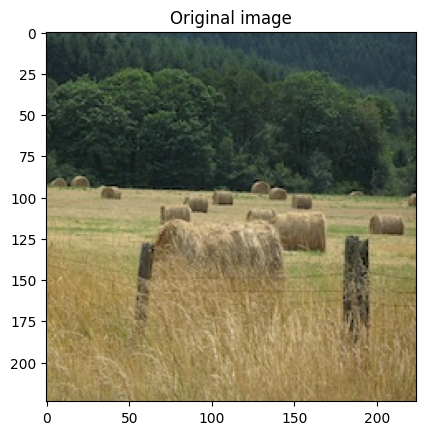


Baseline predictions (top-5):


ValueError: Input 0 of layer "vgg16" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 2, 224, 224, 3)

In [44]:
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from keras.applications import vgg16
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import array_to_img, load_img, img_to_array
model = vgg16.VGG16(weights="imagenet")

# Load JSON describing dataset
with open("data/image_labels.json") as f:
    image_list = json.load(f)

# Pick first entry
item = image_list[7]
image_path = "images/" + item["image"]
target_label = item["label"]

print(f"Loaded image: {image_path}")
print(f"Target label: {target_label}")

img = load_img(image_path)
plt.imshow(img)
plt.title("Original image")
plt.show()

img_array = img_to_array(img)
seed = img_array.copy()

# Print baseline top-5 predictions
print("\nBaseline predictions (top-5):")
preds = model.predict(np.expand_dims(seed, axis=0))
decoded = decode_predictions(preds, top=5)


if decoded[0][0][1] == target_label:
    print(decoded[0][0][2])
else:
    print(-decoded[0][0][2])